In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [22]:
import numpy as np
from option import Option, OptionType
def optimal_price(option: Option, V, eps=1e-6):
    S_min, S_max = np.min(V.x), np.max(V.x)
    if option.type == OptionType.CALL:
        S_axis = np.linspace(option.K, S_max, num=10000)
        idx = np.argmax( np.abs(V(S_axis[1:]) - option.payoff(S_axis[1:])) < eps )
        return S_axis[idx]
    elif option.type == OptionType.PUT:
        S_axis = np.linspace(S_min, option.K, num=10000)
        idx = np.argmin( np.abs(V(S_axis) - option.payoff(S_axis)) < eps ) - 1
        return S_axis[idx]


# Test case 1: American call options without dividends

## Setup

In [23]:
import numpy as np
import pandas as pd
import option
import utils

K = 1
T = 1
call = option.call(K, T)
r = 0.1
sigma = 0.2
delta = 0
S_max = 2
S_test = np.arange(0.8, S_max + 0.1, step=0.2)

In [24]:
import matplotlib.pyplot as plt
V_bopm = np.array([utils.calculate_amer_option(call, si, r, sigma, 1000, delta=delta) for si in S_test])

S_bar 1.0


(-0.01, 0.5)

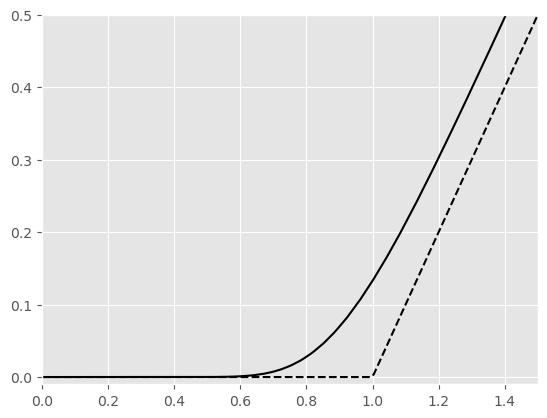

In [25]:
from scipy import interpolate

S_plot = np.linspace(0, 3, num=300)
V_plot = np.array([utils.calculate_amer_option(call, si, r, sigma, 100, delta=delta) for si in S_plot])

S_foo = np.linspace(K, 3, num=1000)
V_foo = interpolate.interp1d(S_plot, V_plot)
print("S_bar", S_foo[np.argmax(np.abs(V_foo(S_foo) - call.payoff(S_foo)) <= 0.00001)])

plt.plot(S_plot, V_plot, '-k')
plt.plot(S_plot, call.payoff(S_plot), '--k')
plt.xlim([0, 1.5])
plt.ylim(bottom=-0.01, top=0.5)

## Nielsen transformation

### Explicit

S_bar 2.1234495441742784
        0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.8  0.002621 -0.010625 -0.013524 -0.002015  -0.000001  0.027907
1.0  0.004706  0.013893  0.013002 -0.029306   0.000891  0.132688
1.2  0.014161  0.200000  0.200000  0.055699   0.025872  0.302596
1.4  0.037339  0.400000  0.400000  0.368943   0.159235  0.496317
1.6  0.060518  0.600000  0.600000  0.600000   0.428869  0.695316
1.8  0.131259  0.800000  0.800000  0.800000   0.733696  0.895181
2.0  0.245200  1.000000  1.000000  1.000000   0.991996  1.095165


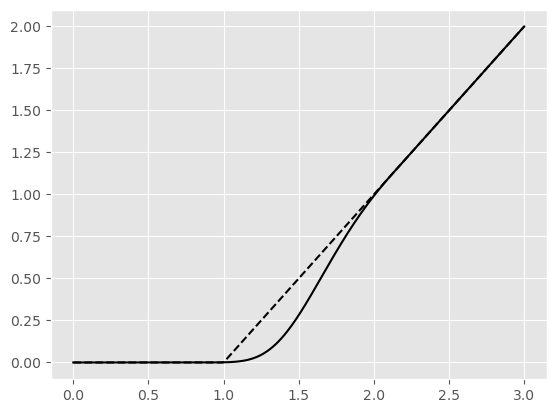

In [26]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V_call, S_bar = nielsen.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta)
    V_call = utils.interpolate_call_amer(call, S_bar, 5, S, V_call)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 3, num=300)  
        plt.plot(S_plot, V_call(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
    V_pred[i] = V_call(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [27]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.125        0.537170
0.0625       0.094567
0.03125      0.094902
0.015625     0.137072
0.0078125    0.212490
dtype: float64

### Implicit

S_bar 38241.90143753404
        0.125    0.0625   0.03125      0.015625  0.0078125      BOPM
0.8  0.000000  0.000000 -0.205959 -1.604973e+05   0.795922  0.027907
1.0  0.004449  0.005186  0.003192 -3.575623e+05   0.994903  0.132688
1.2  0.200000  0.200000  0.200000  1.721827e+05   1.193883  0.302596
1.4  0.400000  0.400000  0.400000 -3.568104e+05   1.392864  0.496317
1.6  0.600000  0.600000  0.600000  1.219693e+06   1.591844  0.695316
1.8  0.800000  0.800000  0.800000 -6.259446e+05   1.790825  0.895181
2.0  1.000000  1.000000  1.000000 -4.666436e+05   1.989806  1.095165


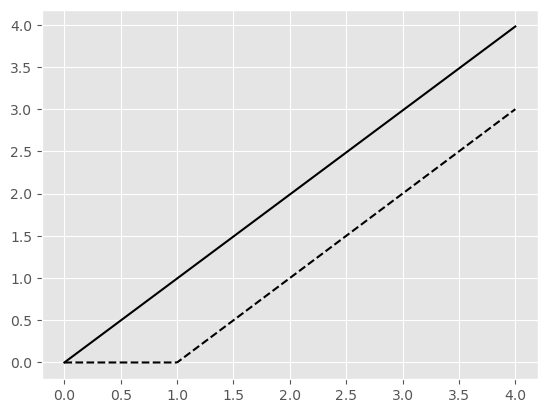

In [28]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = [1/8, 1/16, 1/32, 1/64, 1/128]

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    put = option.put(K, T)
    S, V, S_bar = nielsen.solve_implicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0.2, x_max=3)
    V = utils.interpolate_call_amer(call, S_bar, 5, S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 4, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

## Company transformation

### Explicit

S_bar 0.27948496518390537
         0.25    0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.8  0.000000  0.00000  0.000000  0.000000  0.000062   0.000000  0.027907
1.0  0.002145  0.00481  0.007385  0.002932 -0.069365   0.005883  0.132688
1.2  0.200000  0.20000  0.200000  0.200000  0.196188   0.200000  0.302596
1.4  0.400000  0.40000  0.400000  0.400000  0.400000   0.400000  0.496317
1.6  0.600000  0.60000  0.600000  0.600000  0.600000   0.600000  0.695316
1.8  0.800000  0.80000  0.800000  0.800000  0.800000   0.800000  0.895181
2.0  1.000000  1.00000  1.000000  1.000000  1.000000   1.000000  1.095165


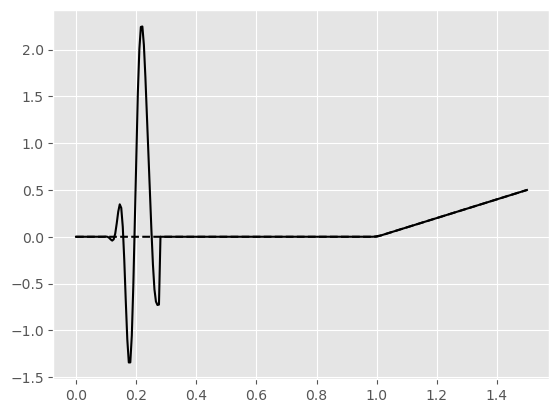

In [29]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen, company
from scipy import interpolate
import timeit

dx = [1/4, 1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V, S_bar = company.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_min=-3)
    S = np.append([0], S)
    V = np.append([0], V)
    V = utils.interpolate_call_amer(call, S_bar, 5, S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [30]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.25         0.096232
0.125        0.095719
0.0625       0.095232
0.03125      0.096080
0.015625     0.113012
0.0078125    0.095515
dtype: float64

## LCP

### Explicit

S_bar 1.0
S_bar 1.0
S_bar 1.0
S_bar 1.0
         0.25     0.125    0.0625   0.03125      BOPM
0.8  0.035986  0.030397  0.028677  0.028005  0.027907
1.0  0.125586  0.131194  0.132382  0.132621  0.132688
1.2  0.311949  0.304792  0.302906  0.302686  0.302596
1.4  0.506524  0.498959  0.496966  0.496474  0.496317
1.6  0.707048  0.698232  0.696046  0.695494  0.695316
1.8  0.908359  0.898438  0.895992  0.895384  0.895181
2.0  1.109923  1.098800  1.096070  1.095391  1.095165
[0.012395858764648438, 0.08434700965881348, 0.6359751224517822, 4.7863452434539795]


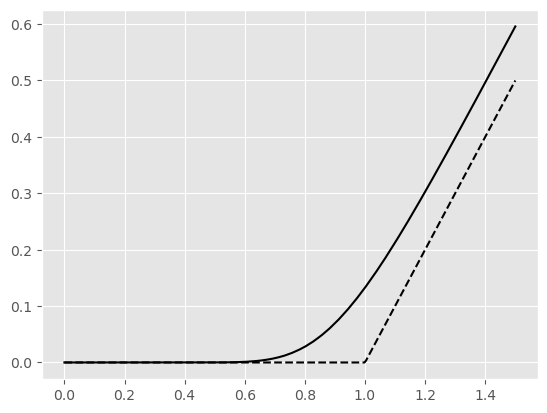

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import time

dx = [1/4, 1/8, 1/16, 1/32]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(call, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [32]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.25       0.010931
0.125      0.002740
0.0625     0.000678
0.03125    0.000156
dtype: float64

### Implicit

         0.25     0.125    0.0625   0.03125      BOPM
0.8  0.041190  0.032857  0.029850  0.028580  0.027907
1.0  0.128311  0.132033  0.132878  0.132870  0.132688
1.2  0.316927  0.306862  0.303863  0.303147  0.302596
1.4  0.513035  0.501775  0.498305  0.497128  0.496317
1.6  0.714570  0.701480  0.697585  0.696247  0.695316
1.8  0.916898  0.902104  0.897722  0.896228  0.895181
2.0  1.119481  1.102900  1.098003  1.096334  1.095165
[0.016037702560424805, 0.07556581497192383, 0.37627243995666504, 2.063272476196289]


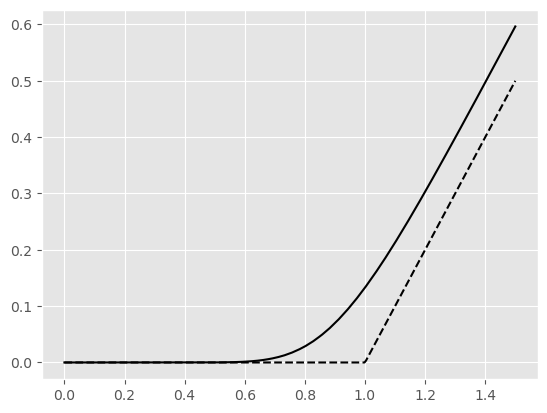

In [33]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import timeit

dx = [1/4, 1/8, 1/16, 1/32]
dt = [1/4, 1/8, 1/16, 1/32]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=1)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [34]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.25       0.017379
0.125      0.005589
0.0625     0.002037
0.03125    0.000826
dtype: float64

### Crank-Nicholson

         0.25     0.125    0.0625   0.03125      BOPM
0.8  0.036521  0.030514  0.028705  0.028011  0.027907
1.0  0.125948  0.131290  0.132405  0.132626  0.132688
1.2  0.312525  0.304918  0.302937  0.302694  0.302596
1.4  0.507260  0.499129  0.497007  0.496484  0.496317
1.6  0.707907  0.698431  0.696095  0.695507  0.695316
1.8  0.909335  0.898664  0.896048  0.895398  0.895181
2.0  1.111015  1.099052  1.096132  1.095406  1.095165
[0.013175725936889648, 0.05398750305175781, 0.2672913074493408, 1.349205493927002]


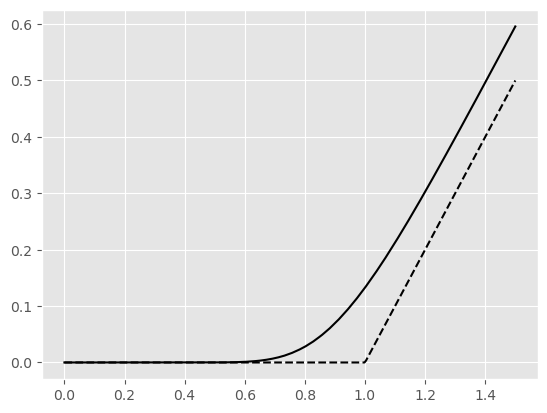

In [35]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import timeit

dx = [1/4, 1/8, 1/16, 1/32]
dt = [1/4, 1/8, 1/16, 1/32]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0.5)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [36]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.25       0.011638
0.125      0.002903
0.0625     0.000717
0.03125    0.000166
dtype: float64

# Test case 2: American put options without dividends

## Setup

In [37]:
import numpy as np
import pandas as pd
import option
import utils
from scipy import interpolate

K = 1
T = 1
put = option.put(K, T)
r = 0.1
sigma = 0.2
S_max = 1.6
S_test = np.arange(0.8, S_max + 0.2, step=0.2)

In [38]:
import matplotlib.pyplot as plt
V_bopm = np.array([utils.calculate_amer_option(put, si, r, sigma, 1000) for si in S_test])

S_bar 1.5


(-0.01, 0.2)

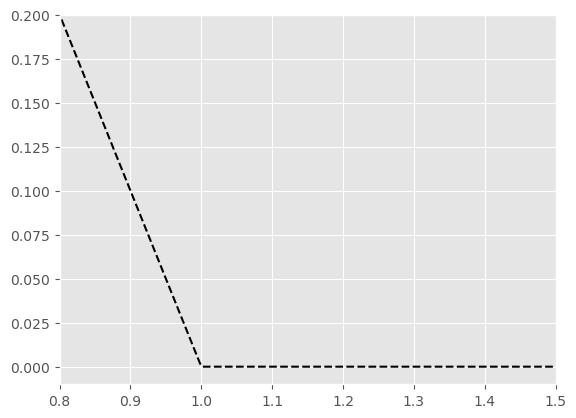

In [39]:
S_plot = np.linspace(0, 1.5, num=500)
V_plot = np.array([utils.calculate_amer_option(put, si, r, sigma, 50) for si in S_plot])

S_foo = np.linspace(0, 1.5, num=1000)
V_foo = interpolate.interp1d(S_plot, V_plot)
print("S_bar", S_foo[np.argmin(np.abs(V_foo(S_foo) - put.payoff(S_foo)) <= 0.00001)-1])

plt.plot(S_plot, V_plot, '-k')
plt.plot(S_plot, put.payoff(S_plot), '--k')
plt.xlim([0.8, 1.5])
plt.ylim(bottom=-0.01,top=0.2)

## Nielsen transformation

### Explicit

S_bar 0.8593814354268935
     0.0078125      BOPM
0.8   0.200000  0.200000
1.0   0.048148  0.048167
1.2   0.008656  0.008666
1.4   0.001283  0.001285
1.6   0.000153  0.000167
[0.14899587631225586]


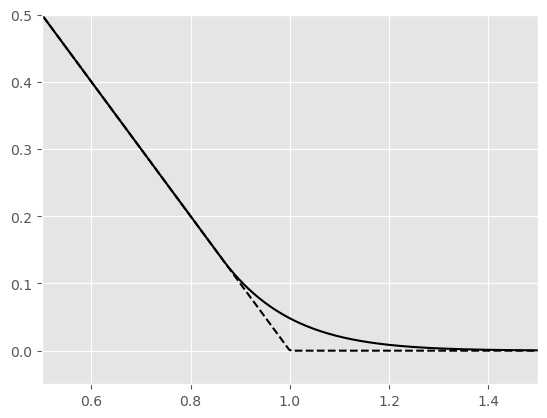

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import time

dx = np.array([1/128])
dt = 2*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V, S_bar = nielsen.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, x_max=2)
    end = time.time()
    cpu_time.append(end - start)
    V = utils.interpolate_put_amer(put, S_bar, S, V)
    V_pred[i] = V(S_test)
    if i == len(dx)-1:
        plt.plot(np.linspace(0, 1.5, num=300), V(np.linspace(0, 1.5, num=300)), '-k')
        plt.plot(np.linspace(0, 1.5, num=300), put.payoff(np.linspace(0, 1.5, num=300)), '--k')
        plt.xlim([0.5, 1.5])
        plt.ylim(top=0.5)
        print("S_bar", S_bar)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [41]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.0078125    0.000012
dtype: float64

### Implicit

S_bar:  0.8580384802033548
        0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.8  0.224810  0.227045  0.200000  0.200000   0.200000  0.200000
1.0  0.156141  0.159308  0.080886  0.053942   0.048944  0.048167
1.2  0.114815  0.117140  0.041319  0.013783   0.009290  0.008666
1.4  0.080638  0.081485  0.023604  0.003694   0.001519  0.001285
1.6  0.047914  0.048026  0.014269  0.001085   0.000229  0.000167
[0.14364218711853027, 0.42818641662597656, 1.3015031814575195, 5.998425483703613, 30.47143292427063]


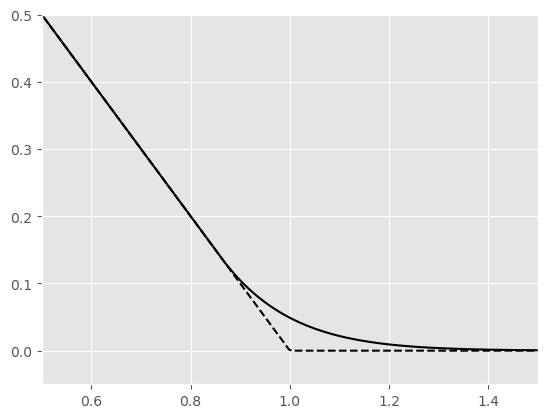

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = [1/8, 1/16, 1/32, 1/64, 1/128]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V_call, S_bar = nielsen.solve_implicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, x_max=3)
    end = time.time()
    cpu_time.append(end - start)
    V = utils.interpolate_put_amer(put, S_bar, S, V_call)
    V_pred[i] = V(S_test)
    if i == len(dx)-1:
        plt.plot(np.linspace(0, 1.5, num=300), V(np.linspace(0, 1.5, num=300)), '-k')
        plt.plot(np.linspace(0, 1.5, num=300), put.payoff(np.linspace(0, 1.5, num=300)), '--k')
        plt.xlim([0.5, 1.5])
        plt.ylim(top=0.5)
        print("S_bar: ", S_bar)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [43]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.125        0.080147
0.0625       0.081942
0.03125      0.023806
0.015625     0.003638
0.0078125    0.000459
dtype: float64

## Company transformation

### Explicit

S_bar 0.8627758976417352
        0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.8  0.200000  0.200000  0.200000  0.200000   0.200000  0.200000
1.0  0.049286  0.049274  0.048465  0.048256   0.048174  0.048167
1.2  0.010736  0.009108  0.008829  0.008686   0.008667  0.008666
1.4  0.001950  0.001501  0.001349  0.001295   0.001287  0.001285
1.6  0.000354  0.000224  0.000185  0.000172   0.000168  0.000167
[0.004670143127441406, 0.009687423706054688, 0.01285409927368164, 0.06098794937133789, 0.2305312156677246]


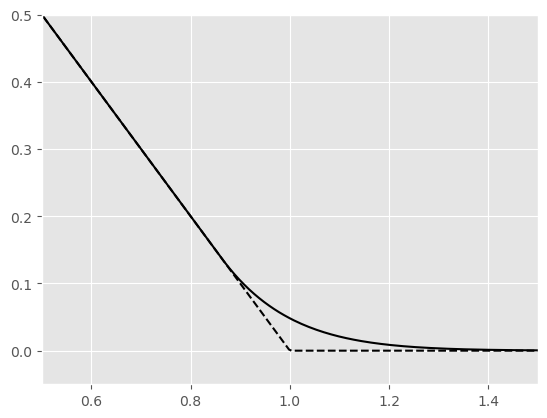

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import company
from scipy import interpolate
import time

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V, S_bar = company.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt
    =dt[i], delta=0, x_max=3)
    end = time.time()
    cpu_time.append(end - start)
    V = utils.interpolate_put_amer(put, S_bar, S, V)
    V_pred[i] = V(S_test)
    if i == len(dx)-1:
        S_p = np.linspace(0, 1.5, num=300)
        print("S_bar", S_bar)
        plt.plot(S_p, V(S_p), '-k')
        plt.plot(S_p, put.payoff(S_p), '--k')
        plt.xlim([0.5, 1.5])
        plt.ylim(top=0.5)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [45]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.125        0.001096
0.0625       0.000542
0.03125      0.000155
0.015625     0.000041
0.0078125    0.000003
dtype: float64

## LCP

### Explicit

S_bar 0.7787778777877788
S_bar 0.8824882488248825
S_bar 0.8824882488248825
S_bar 0.8552855285528553
S_bar 0.8552855285528553
         0.25     0.125    0.0625   0.03125      BOPM
0.8  0.202857  0.200000  0.200000  0.200000  0.200000
1.0  0.029809  0.045502  0.047419  0.047919  0.048167
1.2  0.010550  0.009379  0.008523  0.008646  0.008666
1.4  0.001722  0.001612  0.001350  0.001296  0.001285
1.6  0.000450  0.000273  0.000195  0.000170  0.000167
[0.011339187622070312, 0.08864998817443848, 0.7928650379180908, 5.21365213394165]


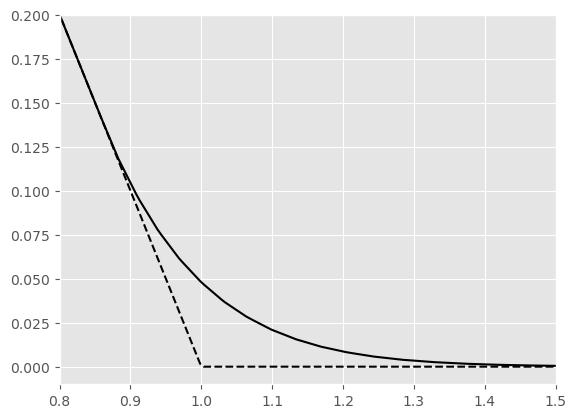

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import time

dx = [1/4, 1/8, 1/16, 1/32]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, theta=0)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(bottom=-0.01,top=0.2)
        print("S_bar", optimal_price(put, V))
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [47]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.25       0.008355
0.125      0.001243
0.0625     0.000342
0.03125    0.000111
dtype: float64

### Implicit

S_bar 0.7787778777877788
S_bar 0.8824882488248825
S_bar 0.8824882488248825
S_bar 0.8552855285528553
S_bar 0.8552855285528553
         0.25     0.125    0.0625   0.03125      BOPM
0.8  0.202837  0.200000  0.200000  0.200000  0.200000
1.0  0.029599  0.045376  0.047392  0.047912  0.048167
1.2  0.010540  0.009365  0.008516  0.008644  0.008666
1.4  0.001778  0.001629  0.001354  0.001297  0.001285
1.6  0.000476  0.000282  0.000198  0.000170  0.000167
[0.04680466651916504, 0.27213430404663086, 2.2903685569763184, 19.17491054534912]


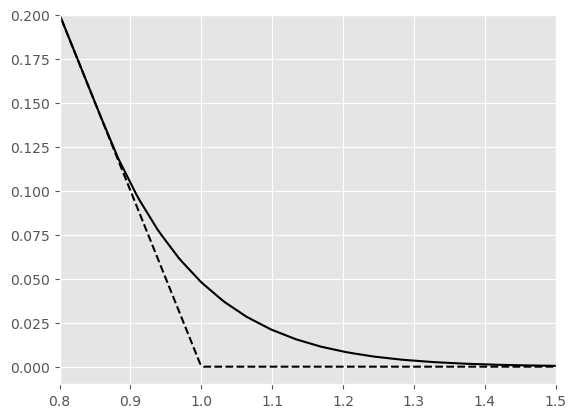

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import time

dx = [1/4, 1/8, 1/16, 1/32]
dt = dt[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, theta=1)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(bottom=-0.01,top=0.2)
        print("S_bar", optimal_price(put, V))
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [49]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.25       0.008446
0.125      0.001297
0.0625     0.000355
0.03125    0.000115
dtype: float64

### Crank-Nicholson

S_bar 0.7787778777877788
S_bar 0.8824882488248825
S_bar 0.8824882488248825
S_bar 0.8552855285528553
S_bar 0.8552855285528553
         0.25     0.125    0.0625   0.03125      BOPM
0.8  0.202847  0.200000  0.200000  0.200000  0.200000
1.0  0.029703  0.045439  0.047406  0.047916  0.048167
1.2  0.010545  0.009372  0.008520  0.008645  0.008666
1.4  0.001750  0.001620  0.001352  0.001296  0.001285
1.6  0.000463  0.000277  0.000197  0.000170  0.000167
[0.030651330947875977, 0.23113059997558594, 2.023820400238037, 17.75186824798584]


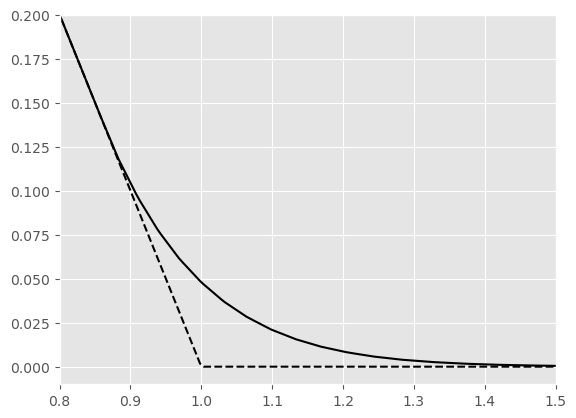

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcp
from scipy import interpolate
import time

dx = [1/4, 1/8, 1/16, 1/32]
dt = dt[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0, theta=0.5)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, 1.5, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(bottom=-0.01,top=0.2)
        print("S_bar", optimal_price(put, V))
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [51]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.25       0.008401
0.125      0.001270
0.0625     0.000348
0.03125    0.000113
dtype: float64

# Test case 3: American call options with dividends

## Setup

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import option
import utils

K = 1
T = 1
call = option.call(K, T)
r = 0.1
sigma = 0.2
delta = 0.09
S_max = 2
S_min = 0
S_test = np.arange(S_min, S_max, step=0.2)

In [53]:
from scipy import interpolate
S_plot = np.linspace(S_min, S_max, num=100)
V_plot = np.array([utils.calculate_amer_option(call, si, r, sigma, 100, delta=delta) for si in S_plot])

S_foo = np.linspace(K, S_max, num=1000)
V_foo = interpolate.interp1d(S_plot, V_plot, kind='cubic')
print("S_bar", S_foo[np.argmax(np.abs(V_foo(S_foo) - call.payoff(S_foo)) <= 0.00001)])

S_bar 1.3923923923923924


(-0.01, 0.4)

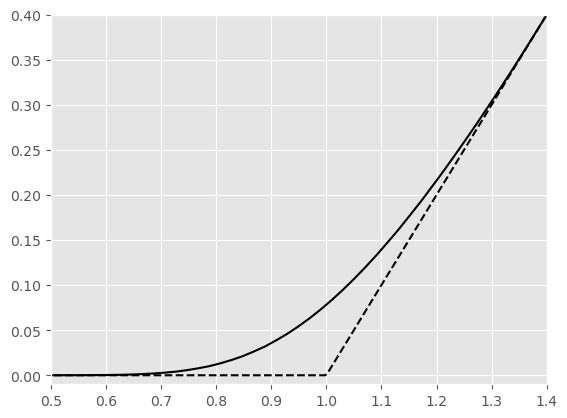

In [54]:
plt.plot(S_plot, V_plot, '-k')
payoff_linspace = np.linspace(0, S_max, num=500)
plt.plot(payoff_linspace, call.payoff(payoff_linspace), '--k')
plt.xlim(left=0.5,right=1.4)
plt.ylim(bottom=-0.01, top=0.4)

In [55]:
import matplotlib.pyplot as plt
V_bopm = np.array([utils.calculate_amer_option(call, si, r, sigma, 1000, delta=delta) for si in S_test])
V_bopm

array([0.00000000e+00, 4.32567691e-18, 6.57119229e-08, 2.77152073e-04,
       1.19620830e-02, 7.80629718e-02, 2.15901489e-01, 4.00000000e-01,
       6.00000000e-01, 8.00000000e-01])

## Nielsen transformation

### Explicit

S_bar 1.767951991998504
        0.125        0.0625       0.03125      0.015625     0.0078125  \
0.0  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.2  0.000005  2.741526e-08  2.233460e-11 -1.594350e-17  4.495987e-17   
0.4  0.000199  1.341004e-05  6.737251e-07  7.707904e-14  2.142313e-08   
0.6  0.002825  8.666214e-04  4.282597e-04  5.371894e-11 -4.376920e-05   
0.8  0.020077  1.359774e-02  1.225526e-02  4.550120e-09  4.019708e-03   
1.0  0.081944  7.741973e-02  7.817040e-02 -2.307112e-07 -8.268380e-02   
1.2  0.213546  2.149790e-01  2.154420e-01 -2.496452e-05  4.594095e-02   
1.4  0.400000  4.000000e-01  4.000000e-01 -6.145165e-04  4.123131e-01   
1.6  0.600000  6.000000e-01  6.000000e-01 -6.121670e-03  6.161271e-01   
1.8  0.800000  8.000000e-01  8.000000e-01 -2.610611e-02  8.000000e-01   

             BOPM  
0.0  0.000000e+00  
0.2  4.325677e-18  
0.4  6.571192e-08  
0.6  2.771521e-04  
0.8  1.196208e-02  
1.0  7.806297e-02  
1.2  2.159015e-01  
1.4  4.00000

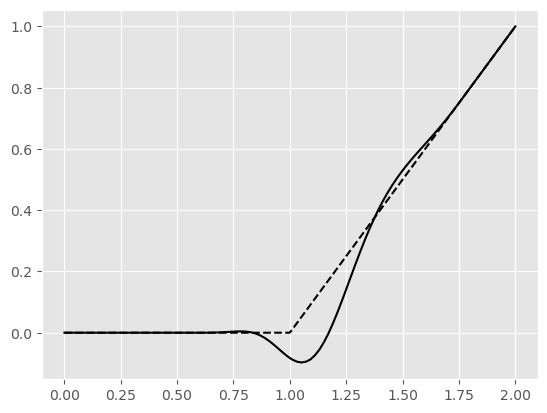

In [56]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V, S_bar = nielsen.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta)
    V = utils.interpolate_call_amer(call, S_bar, S_max+2, S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=100)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(payoff_linspace, call.payoff(payoff_linspace), '--k')
        print("S_bar", S_bar)
        # plt.xlim(left=0.7,right=1.1)
        # plt.ylim(top=0.1, bottom=-0.01)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [57]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.125        0.003050
0.0625       0.000655
0.03125      0.000182
0.015625     0.355414
0.0078125    0.074297
dtype: float64

### Implicit

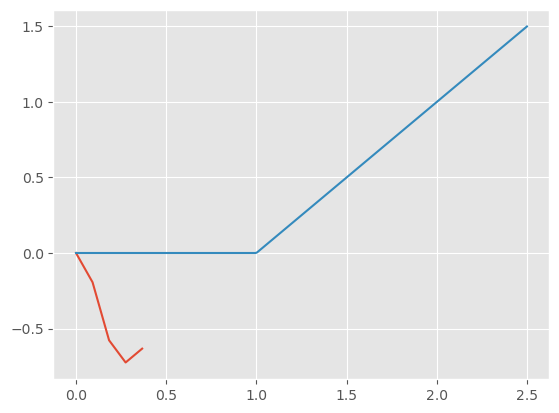

In [58]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/4]#[1/8, 1/16, 1/32, 1/64, 1/128]
dt = [1/4]#[1/8, 1/16, 1/32, 1/64, 1/128]

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    put = option.put(K, T)
    S, V_call, S_bar = nielsen.solve_implicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=0.2, x_max=3)
    plt.plot(S, V_call)
    plt.plot(np.linspace(0, 2.5, num=300) , call.payoff(np.linspace(0, 2.5, num=300)))
#     V_put = utils.interpolate_call_amer(call, S_bar, 5, S, V_put)
#     if i == len(dx)-1:
#         S_plot = np.linspace(0, 2.5, num=300)  
#         plt.plot(S_plot, V_put(S_plot), '-k')
#         plt.plot(S_plot, call.payoff(S_plot), '--k')
#         print("S_bar", S_bar)
#     V_pred[i] = V_put(S_test)
# table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
# table.loc['BSF'] = V_bopm[:]
# print(table.T)

## Company transformation

### Explicit

S_bar 1.791739983962104
            0.125        0.0625       0.03125      0.015625     0.0078125  \
0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.2  1.269588e-10  1.762708e-13  7.303540e-16 -1.526074e-20 -1.566950e-21   
0.4  5.554378e-06  6.447499e-07  1.618707e-07  2.640403e-09  4.364866e-09   
0.6  9.586783e-04  4.780077e-04  3.262013e-04  5.276353e-05 -9.334250e-05   
0.8  1.533479e-02  1.280534e-02  1.217203e-02 -1.180289e-02  8.890932e-03   
1.0  8.025510e-02  7.850294e-02  7.808869e-02 -1.145545e-01 -1.091847e-01   
1.2  2.145179e-01  2.159216e-01  2.157029e-01  1.229910e-01 -7.844781e-03   
1.4  4.000000e-01  4.000000e-01  4.000207e-01  4.019844e-01  4.398074e-01   
1.6  6.000000e-01  6.000000e-01  6.000000e-01  6.000000e-01  6.255474e-01   
1.8  8.000000e-01  8.000000e-01  8.000000e-01  8.000000e-01  8.000000e-01   

             BOPM  
0.0  0.000000e+00  
0.2  4.325677e-18  
0.4  6.571192e-08  
0.6  2.771521e-04  
0.8  1.196208e-02  
1.0  7.8

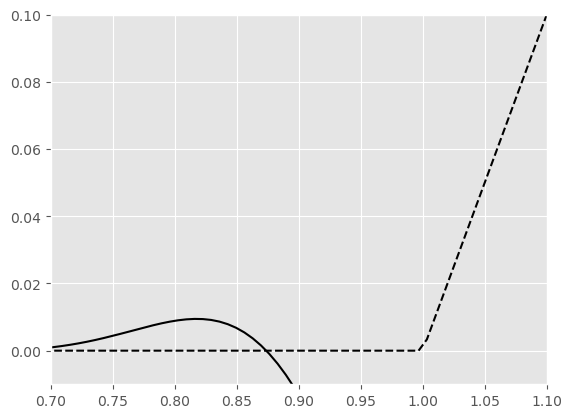

In [59]:
import numpy as np
import pandas as pd
import option
import matplotlib.pyplot as plt
from frontfixing import nielsen, company
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
for i in range(len(dx)):
    S, V, S_bar = company.solve_explicitly(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_min=-3)
    S = np.append([0], S)
    V = np.append([0], V)
    V = utils.interpolate_call_amer(call, S_bar, S_max+5, S, V)
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        print("S_bar", S_bar)
        plt.xlim(left=0.7,right=1.1)
        plt.ylim(top=0.1, bottom=-0.01)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)

In [60]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

0.125        0.001362
0.0625       0.000307
0.03125      0.000093
0.015625     0.068046
0.0078125    0.093472
dtype: float64

## LCP

### Explicit

S_bar 1.4542812068925557
S_bar 1.4504637177590047
S_bar 1.4084713372899451
            0.125        0.0625       0.03125          BOPM
0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
0.2  4.115172e-12  1.023839e-14  1.299741e-16  4.325677e-18
0.4  1.306647e-06  2.540313e-07  1.030208e-07  6.571192e-08
0.6  4.226899e-04  3.254087e-04  2.929324e-04  2.771521e-04
0.8  1.245525e-02  1.216791e-02  1.194989e-02  1.196208e-02
1.0  7.426691e-02  7.718871e-02  7.785845e-02  7.806297e-02
1.2  2.166950e-01  2.156212e-01  2.158633e-01  2.159015e-01
1.4  4.011224e-01  4.000128e-01  4.000905e-01  4.000000e-01
1.6  6.000000e-01  6.000000e-01  6.000000e-01  6.000000e-01
1.8  8.000000e-01  8.000000e-01  8.000000e-01  8.000000e-01
[0.08850574493408203, 0.6795198917388916, 4.909600257873535]


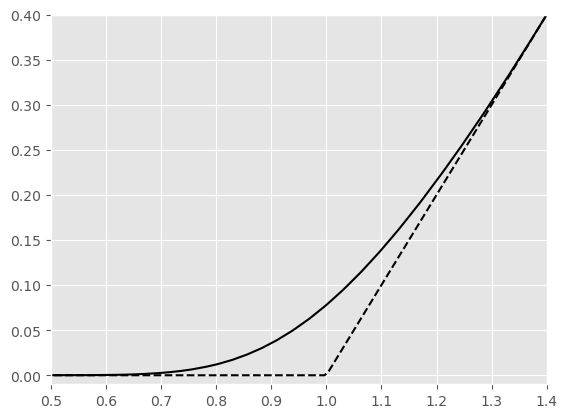

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0)
    end = time.time()
    cpu_time.append(end-start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(call, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        plt.xlim(left=0.5,right=1.4)
        plt.ylim(bottom=-0.01, top=0.4)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [62]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.125      0.001287
0.0625     0.000298
0.03125    0.000072
dtype: float64

### Implicit

S_bar 1.4542812068925557
S_bar 1.4504637177590047
S_bar 1.4084713372899451
            0.125        0.0625       0.03125          BOPM
0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
0.2  1.002662e-11  1.889965e-14  1.774579e-16  4.325677e-18
0.4  1.657374e-06  2.875839e-07  1.080157e-07  6.571192e-08
0.6  4.473927e-04  3.320902e-04  2.946457e-04  2.771521e-04
0.8  1.249191e-02  1.217550e-02  1.195172e-02  1.196208e-02
1.0  7.409845e-02  7.715279e-02  7.784947e-02  7.806297e-02
1.2  2.166740e-01  2.156092e-01  2.158599e-01  2.159015e-01
1.4  4.011329e-01  4.000141e-01  4.000905e-01  4.000000e-01
1.6  6.000000e-01  6.000000e-01  6.000000e-01  6.000000e-01
1.8  8.000000e-01  8.000000e-01  8.000000e-01  8.000000e-01
[0.44510316848754883, 3.5517749786376953, 24.952749729156494]


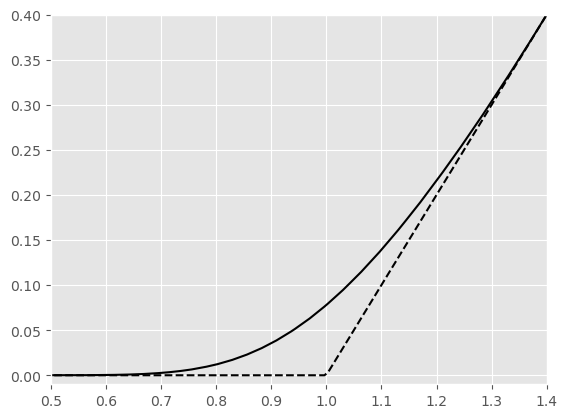

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = dt[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=1)
    end = time.time()
    cpu_time.append(end-start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(call, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        plt.xlim(left=0.5,right=1.4)
        plt.ylim(bottom=-0.01, top=0.4)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [64]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.125      0.001338
0.0625     0.000310
0.03125    0.000075
dtype: float64

### Crank-Nicholson

S_bar 1.4542812068925557
S_bar 1.4504637177590047
S_bar 1.4084713372899451
            0.125        0.0625       0.03125          BOPM
0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
0.2  6.577216e-12  1.403275e-14  1.521865e-16  4.325677e-18
0.4  1.477070e-06  2.705364e-07  1.055028e-07  6.571192e-08
0.6  4.350671e-04  3.287524e-04  2.937892e-04  2.771521e-04
0.8  1.247350e-02  1.217169e-02  1.195080e-02  1.196208e-02
1.0  7.418267e-02  7.717074e-02  7.785396e-02  7.806297e-02
1.2  2.166841e-01  2.156152e-01  2.158616e-01  2.159015e-01
1.4  4.011276e-01  4.000134e-01  4.000905e-01  4.000000e-01
1.6  6.000000e-01  6.000000e-01  6.000000e-01  6.000000e-01
1.8  8.000000e-01  8.000000e-01  8.000000e-01  8.000000e-01
[0.41773462295532227, 2.949418544769287, 22.147475004196167]


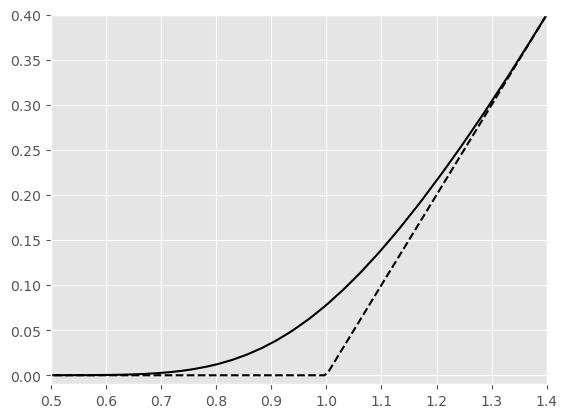

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = dt[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(call, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0.5)
    end = time.time()
    cpu_time.append(end-start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(call, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, call.payoff(S_plot), '--k')
        plt.xlim(left=0.5,right=1.4)
        plt.ylim(bottom=-0.01, top=0.4)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [66]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.125      0.001313
0.0625     0.000304
0.03125    0.000073
dtype: float64

# Test case 4: American put options with dividends

## Setup

In [67]:
import numpy as np
import pandas as pd
import option
import utils
from scipy import interpolate
import matplotlib.pyplot as plt
K = 1
T = 1
put = option.put(K, T)
r = 0.1
sigma = 0.2
delta=0.03
S_max = 1.5
dx = 0.2
S_test = np.arange(0, S_max + dx, step=dx)

S_bar 0.8333333333333334


(-0.01, 0.2)

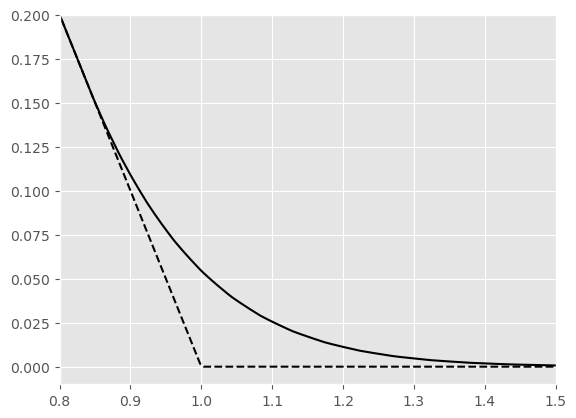

In [68]:
S_plot = np.linspace(0, 1.5, num=300)
V_plot = np.array([utils.calculate_amer_option(put, si, r, sigma, 100, delta=delta) for si in S_plot])
S_foo = np.linspace(0, 1.5, num=100)
V_foo = interpolate.interp1d(S_plot, V_plot)
print("S_bar", S_foo[np.argmin(np.abs(V_foo(S_foo) - put.payoff(S_foo)) <= 0.00001)-1])

plt.plot(S_plot, V_plot, '-k')
plt.plot(S_plot, put.payoff(S_plot), '--k')
plt.xlim([0.8, 1.5])
plt.ylim(top=0.2, bottom=-0.01)

In [69]:
import matplotlib.pyplot as plt
V_bopm = np.array([utils.calculate_amer_option(put, si, r, sigma, 100, delta=delta) for si in S_test])
V_bopm

array([1.00000000e+00, 8.00000000e-01, 6.00000000e-01, 4.00000000e-01,
       2.00000000e-01, 5.44636827e-02, 1.12547366e-02, 1.85544849e-03,
       2.61937379e-04])

## Nielsen transformation

### Explicit

S_bar 0.835877810246602
        0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.0  1.000000  1.000000  1.000000  1.000000   1.000000  1.000000
0.2  0.800000  0.800000  0.800000  0.800000   0.800000  0.800000
0.4  0.600000  0.600000  0.600000  0.600000   0.600000  0.600000
0.6  0.400000  0.400000  0.400000  0.400000   0.400000  0.400000
0.8  0.200000  0.200000  0.200000  0.200000   0.200000  0.200000
1.0  0.053355  0.054588  0.054501  0.054465   0.054469  0.054464
1.2  0.011585  0.011457  0.011255  0.011179   0.011161  0.011255
1.4  0.002219  0.002006  0.001889  0.001857   0.001847  0.001855
1.6  0.000399  0.000315  0.000277  0.000268   0.000265  0.000262
[0.00474    0.01616406 0.05854249 0.16374946 0.36487651]


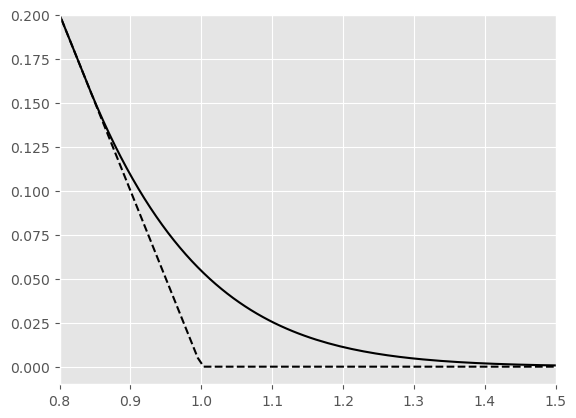

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import time

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V_put, S_bar = nielsen.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_max=3)
    end = time.time()
    cpu_time.append(end - start)
    V_put = utils.interpolate_put_amer(put, S_bar, S, V_put)
    if i == len(dx)-1:
        S_foo = np.linspace(0, 2.5, num=300)
        plt.plot(S_foo, V_put(S_foo), '-k')
        plt.plot(S_foo, put.payoff(S_foo), '--k')
        print("S_bar", S_bar)
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
    V_pred[i] = V_put(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(np.array(cpu_time))

In [71]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values
# (V_bsf - table.loc[dx])

array([4.06919100e-04, 9.54919827e-05, 1.76523722e-05, 2.53911985e-05,
       3.14637929e-05])

### Implicit

S_bar:  0.8339657042349816
        0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.0  1.000000  1.000000  1.000000  1.000000   1.000000  1.000000
0.2  0.800000  0.800000  0.800000  0.800000   0.800000  0.800000
0.4  0.600000  0.600000  0.600000  0.600000   0.600000  0.600000
0.6  0.400000  0.400000  0.400000  0.400000   0.400000  0.400000
0.8  0.231919  0.232342  0.200233  0.200000   0.200000  0.200000
1.0  0.163548  0.162967  0.089615  0.061152   0.055593  0.054464
1.2  0.120873  0.120457  0.047015  0.017301   0.012096  0.011255
1.4  0.085831  0.085467  0.027217  0.004933   0.002225  0.001855
1.6  0.050554  0.051585  0.016645  0.001508   0.000373  0.000262
[ 0.11433005  0.41819596  1.30289674  5.66329551 29.22956395]


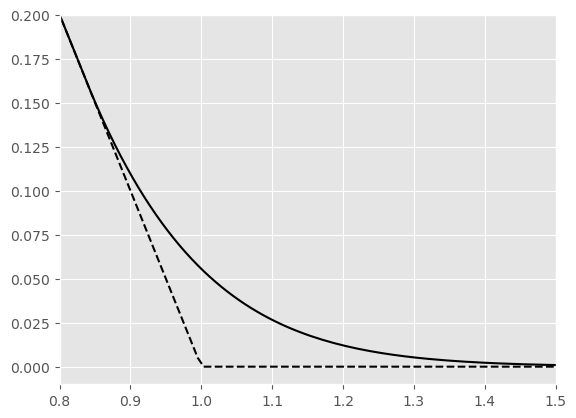

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import timeit

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = [1/8, 1/16, 1/32, 1/64, 1/128]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V_call, S_bar = nielsen.solve_implicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_max=3)
    end = time.time()
    cpu_time.append(end - start)
    V_put = utils.interpolate_put_amer(put, S_bar, S, V_call)
    V_pred[i] = V_put(S_test)
    if i == len(dx)-1:
        S_foo = np.linspace(0, 2.5, num=300)
        plt.plot(S_foo, V_put(S_foo), '-k')
        plt.plot(S_foo, put.payoff(S_foo), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
        print("S_bar: ", S_bar)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(np.array(cpu_time))

In [73]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values

array([0.061928  , 0.0617965 , 0.01951102, 0.00320262, 0.00048678])

## Company transformation

### Explicit

S_bar 0.8391763013729908
        0.125    0.0625   0.03125  0.015625  0.0078125      BOPM
0.0  1.000000  1.000000  1.000000  1.000000   1.000000  1.000000
0.2  0.800000  0.800000  0.800000  0.800000   0.800000  0.800000
0.4  0.600000  0.600000  0.600000  0.600000   0.600000  0.600000
0.6  0.400000  0.400000  0.400000  0.400000   0.400000  0.400000
0.8  0.200000  0.200000  0.200000  0.200000   0.200000  0.200000
1.0  0.058211  0.055260  0.054777  0.054530   0.054491  0.054464
1.2  0.013032  0.011827  0.011360  0.011192   0.011167  0.011255
1.4  0.002438  0.002104  0.001935  0.001866   0.001850  0.001855
1.6  0.000530  0.000365  0.000294  0.000272   0.000266  0.000262
[0.00318551 0.00670862 0.02266908 0.0490582  0.18164277]


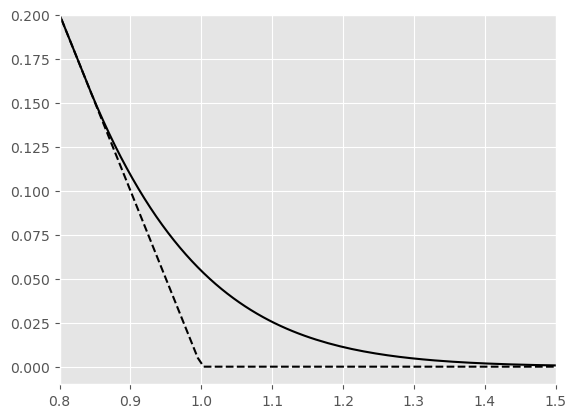

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from frontfixing import nielsen
from scipy import interpolate
import time

dx = [1/8, 1/16, 1/32, 1/64, 1/128]
dt = 0.5*np.power(dx, 2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V_put, S_bar = company.solve_explicitly(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, x_max=3)
    end = time.time()
    cpu_time.append(end - start)
    V_put = utils.interpolate_put_amer(put, S_bar, S, V_put)
    if i == len(dx)-1:
        S_foo = np.linspace(0, 2.5, num=300)
        plt.plot(S_foo, V_put(S_foo), '-k')
        plt.plot(S_foo, put.payoff(S_foo), '--k')
        print("S_bar", S_bar)
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
    V_pred[i] = V_put(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,2))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(np.array(cpu_time))

In [75]:
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5).values

array([1.39870377e-03, 3.39074839e-04, 1.13724253e-04, 3.08799303e-05,
       3.08869048e-05])

## LCP

### Explicit

S_bar 0.7804780478047805
S_bar 0.828982898289829
S_bar 0.8290829082908291
        0.125    0.0625   0.03125      BOPM
0.0  1.000000  1.000000  1.000000  1.000000
0.2  0.800000  0.800000  0.800000  0.800000
0.4  0.600000  0.600000  0.600000  0.600000
0.6  0.400000  0.400000  0.400000  0.400000
0.8  0.200012  0.200000  0.200000  0.200000
1.0  0.050816  0.053478  0.054246  0.054464
1.2  0.011815  0.010956  0.011134  0.011255
1.4  0.002273  0.001933  0.001860  0.001855
1.6  0.000425  0.000308  0.000268  0.000262
[0.0772559642791748, 0.574641227722168, 4.549388885498047]


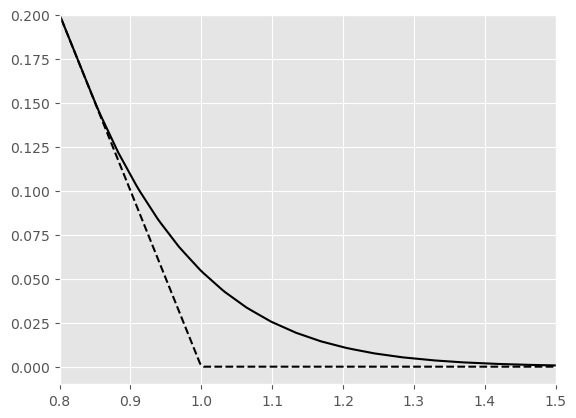

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = 0.5*np.power(dx,2)

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [77]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.125      0.001239
0.0625     0.000345
0.03125    0.000083
dtype: float64

### Implicit

S_bar 0.784978497849785
S_bar 0.828982898289829
S_bar 0.8290829082908291
        0.125    0.0625   0.03125      BOPM
0.0  1.000000  1.000000  1.000000  1.000000
0.2  0.800000  0.800000  0.800000  0.800000
0.4  0.600000  0.600000  0.600000  0.600000
0.6  0.400000  0.400000  0.400000  0.400000
0.8  0.200003  0.200000  0.200000  0.200000
1.0  0.049518  0.052936  0.053968  0.054464
1.2  0.011651  0.010840  0.011063  0.011255
1.4  0.002455  0.002030  0.001908  0.001855
1.6  0.000541  0.000370  0.000300  0.000262
[0.03584480285644531, 0.22100162506103516, 1.2271497249603271]


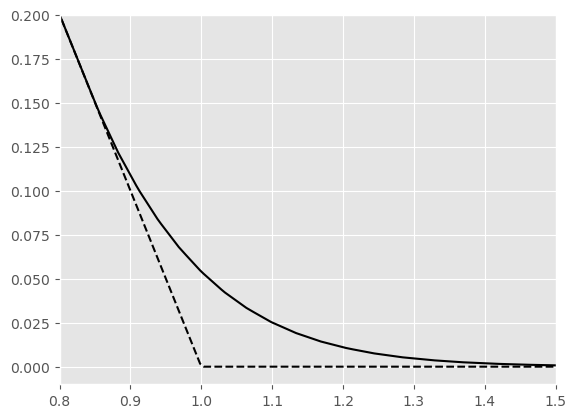

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = dx[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=1)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [79]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.125      0.001668
0.0625     0.000532
0.03125    0.000179
dtype: float64

### Crank-Nicholson

S_bar 0.7862786278627864
S_bar 0.828982898289829
S_bar 0.8290829082908291
        0.125    0.0625   0.03125      BOPM
0.0  1.000000  1.000000  1.000000  1.000000
0.2  0.800000  0.800000  0.800000  0.800000
0.4  0.600000  0.600000  0.600000  0.600000
0.6  0.400000  0.400000  0.400000  0.400000
0.8  0.200003  0.200000  0.200000  0.200000
1.0  0.050792  0.053479  0.054239  0.054464
1.2  0.011799  0.010956  0.011129  0.011255
1.4  0.002278  0.001935  0.001858  0.001855
1.6  0.000432  0.000310  0.000268  0.000262
[0.02564382553100586, 0.1512453556060791, 0.7819976806640625]


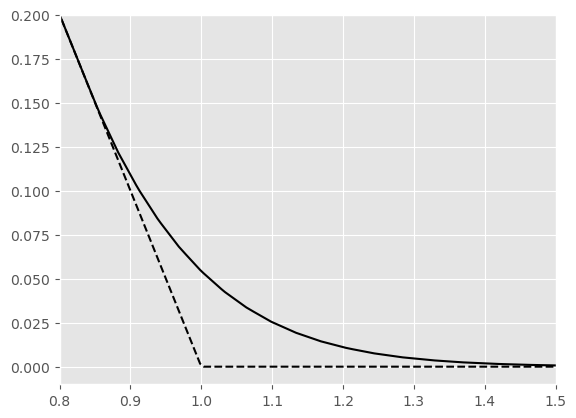

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import lcp
import time

dx = [1/8, 1/16, 1/32]
dt = dx[:]

V_pred = np.empty((len(dx), len(S_test)))
cpu_time = []
for i in range(len(dx)):
    start = time.time()
    S, V = lcp.solve(put, r=r,sigma=sigma, dx=dx[i], dt=dt[i], delta=delta, theta=0.5)
    end = time.time()
    cpu_time.append(end - start)
    V = interpolate.interp1d(S, V)
    print("S_bar", optimal_price(put, V))
    if i == len(dx)-1:
        S_plot = np.linspace(0, S_max, num=300)  
        plt.plot(S_plot, V(S_plot), '-k')
        plt.plot(S_plot, put.payoff(S_plot), '--k')
        plt.xlim([0.8, 1.5])
        plt.ylim(top=0.2, bottom=-0.01)
    V_pred[i] = V(S_test)
table = pd.DataFrame(V_pred, index=dx, columns=np.round(S_test,1))
table.loc['BOPM'] = V_bopm[:]
print(table.T)
print(cpu_time)

In [81]:
print("Root Mean squared error")
(V_bopm - table.loc[dx]).pow(2).mean(axis=1).pow(0.5)

Root Mean squared error


0.125      0.001247
0.0625     0.000345
0.03125    0.000086
dtype: float64